In [1]:
%load_ext watermark


In [2]:
from IPython.display import display
import pandas as pd
import polars as pl
import seaborn as sns
from teeplot import teeplot as tp

from pylib.munge._calc_fixprobs_from_traits import calc_fixprobs_from_traits
from pylib.viz._get_nben_cmap import get_nben_cmap
from pylib.viz._get_nben_hue_norm import get_nben_hue_norm
from pylib.viz._size_fixation_cliffplot import size_fixation_cliffplot
from pylib.viz._size_fixation_heatmap import size_fixation_heatmap


In [3]:
%watermark -diwmuv -iv


Last updated: 2024-10-16T00:10:13.101665+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.31.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.5.0-1025-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

teeplot: 1.1.3
seaborn: 0.13.2
pandas : 2.2.3
polars : 1.9.0

Watermark: 2.4.3



In [4]:
teeplot_subdir = "cupy-5050-spatial2d-traits"
teeplot_subdir


'cupy-5050-spatial2d-traits'

## Prep Data


In [5]:
dfpd = pd.read_parquet("https://osf.io/8q5v6/download")
display(dfpd.describe()), display(dfpd.head()), display(dfpd.tail());


,trait count,trait cycle last seen,trait value,tile,row,col,globalSeed,nCol,nRow,nWav,nTrait,nCycle,nColSubgrid,nRowSubgrid,tilePopSize,tournSize,msec,tsc,nBen
count,8.266860e+06,8.266860e+06,8266860.0,8.266860e+06,8.266860e+06,8.266860e+06,8.266860e+06,8266860.0,8266860.0,8266860.0,8266860.0,8266860.0,8.266860e+06,8.266860e+06,8266860.0,8.266860e+06,8266860.0,8266860.0,8.266860e+06
mean,1.280000e+02,2.509735e+05,0.5,2.952400e+04,1.210000e+02,1.210000e+02,7.500000e+00,243.0,243.0,1.0,2.0,500000.0,1.648571e+02,1.648571e+02,256.0,1.099989e+00,0.0,0.0,3.600000e+00
std,1.280000e+02,2.490414e+05,0.5,1.704598e+04,7.014747e+01,7.014747e+01,4.031129e+00,0.0,0.0,0.0,0.0,0.0,1.063457e+02,1.063457e+02,0.0,0.000000e+00,0.0,0.0,2.416609e+00
min,0.000000e+00,2.200000e+01,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,243.0,243.0,1.0,2.0,500000.0,1.000000e+00,1.000000e+00,256.0,1.100000e+00,0.0,0.0,1.000000e+00
25%,0.000000e+00,2.110000e+02,0.0,1.476200e+04,6.000000e+01,6.000000e+01,4.000000e+00,243.0,243.0,1.0,2.0,500000.0,2.700000e+01,2.700000e+01,256.0,1.100000e+00,0.0,0.0,2.000000e+00
50%,1.280000e+02,2.643655e+05,0.5,2.952400e+04,1.210000e+02,1.210000e+02,7.500000e+00,243.0,243.0,1.0,2.0,500000.0,2.430000e+02,2.430000e+02,256.0,1.100000e+00,0.0,0.0,3.000000e+00
75%,2.560000e+02,4.999990e+05,1.0,4.428600e+04,1.820000e+02,1.820000e+02,1.100000e+01,243.0,243.0,1.0,2.0,500000.0,2.430000e+02,2.430000e+02,256.0,1.100000e+00,0.0,0.0,4.000000e+00
max,2.560000e+02,4.999990e+05,1.0,5.904800e+04,2.420000e+02,2.420000e+02,1.400000e+01,243.0,243.0,1.0,2.0,500000.0,2.430000e+02,2.430000e+02,256.0,1.100000e+00,0.0,0.0,8.000000e+00


,trait count,trait cycle last seen,trait value,tile,row,col,genomeFlavor,globalSeed,nCol,nRow,...,nTrait,nCycle,nColSubgrid,nRowSubgrid,tilePopSize,tournSize,msec,tsc,replicate,nBen
0,256,499999,0,0,0,0,genome_cupy_1xl_5050_poisson,7,243,243,...,2,500000,243,243,256,1.1,0.0,0,67b81b03-cc54-44f9-8baa-1968f04bd2d0,1
1,0,3352,1,0,0,0,genome_cupy_1xl_5050_poisson,7,243,243,...,2,500000,243,243,256,1.1,0.0,0,67b81b03-cc54-44f9-8baa-1968f04bd2d0,1
2,256,499999,0,1,1,0,genome_cupy_1xl_5050_poisson,7,243,243,...,2,500000,243,243,256,1.1,0.0,0,67b81b03-cc54-44f9-8baa-1968f04bd2d0,1
3,0,3387,1,1,1,0,genome_cupy_1xl_5050_poisson,7,243,243,...,2,500000,243,243,256,1.1,0.0,0,67b81b03-cc54-44f9-8baa-1968f04bd2d0,1
4,256,499999,0,2,2,0,genome_cupy_1xl_5050_poisson,7,243,243,...,2,500000,243,243,256,1.1,0.0,0,67b81b03-cc54-44f9-8baa-1968f04bd2d0,1


,trait count,trait cycle last seen,trait value,tile,row,col,genomeFlavor,globalSeed,nCol,nRow,...,nTrait,nCycle,nColSubgrid,nRowSubgrid,tilePopSize,tournSize,msec,tsc,replicate,nBen
8266855,256,499999,1,59046,240,242,genome_cupy_3xl_5050_poisson,14,243,243,...,2,500000,243,243,256,1.1,0.0,0,81d3a54b-2532-4d49-9ee8-80f51626b876,3
8266856,0,214,0,59047,241,242,genome_cupy_3xl_5050_poisson,14,243,243,...,2,500000,243,243,256,1.1,0.0,0,81d3a54b-2532-4d49-9ee8-80f51626b876,3
8266857,256,499999,1,59047,241,242,genome_cupy_3xl_5050_poisson,14,243,243,...,2,500000,243,243,256,1.1,0.0,0,81d3a54b-2532-4d49-9ee8-80f51626b876,3
8266858,0,216,0,59048,242,242,genome_cupy_3xl_5050_poisson,14,243,243,...,2,500000,243,243,256,1.1,0.0,0,81d3a54b-2532-4d49-9ee8-80f51626b876,3
8266859,256,499999,1,59048,242,242,genome_cupy_3xl_5050_poisson,14,243,243,...,2,500000,243,243,256,1.1,0.0,0,81d3a54b-2532-4d49-9ee8-80f51626b876,3


In [6]:
(apn,) = dfpd["tilePopSize"].unique()  # agents per node
apn


np.uint16(256)

In [7]:
dfxs = calc_fixprobs_from_traits(dfpd)
display(dfxs.describe()), display(dfxs.head()), display(dfxs.tail());


100%|██████████| 70/70 [00:00<00:00, 316.42it/s]


,group,trait value,replicate,population size,available beneficial mutations,fixation probability
count,664380.000000,664380.0,6.643800e+05,6.643800e+05,664380.000000,664380.0
mean,27240.309401,0.5,8.797299e+18,3.185400e+03,3.600000,0.5
std,17426.555895,0.5,5.924919e+18,1.771294e+05,2.416611,0.5
min,0.000000,0.0,5.629117e+16,2.560000e+02,1.000000,0.0
25%,11812.000000,0.0,4.633887e+18,2.560000e+02,2.000000,0.0
50%,25829.500000,0.5,5.828273e+18,2.560000e+02,3.000000,0.5
75%,42439.000000,1.0,1.160106e+19,2.560000e+02,4.000000,1.0
max,59048.000000,1.0,1.807610e+19,1.511654e+07,8.000000,1.0


,group,trait value,replicate,population size,available beneficial mutations,fixation probability,genotype
0,0,0,16718381540940362211,15116544,1,1.0,normomutator
1,0,1,16718381540940362211,15116544,1,0.0,hypermutator
2,10939,0,4765690112321800547,2304,1,0.0,normomutator
3,8749,1,4765690112321800547,2304,1,1.0,hypermutator
4,11921,1,4765690112321800547,2304,1,1.0,hypermutator


,group,trait value,replicate,population size,available beneficial mutations,fixation probability,genotype
664375,0,1,14681267517012933180,15116544,3,1.0,hypermutator
664376,0,0,4369920558989525674,15116544,3,0.0,normomutator
664377,0,1,4369920558989525674,15116544,3,1.0,hypermutator
664378,0,1,330434490859514516,15116544,3,1.0,hypermutator
664379,0,0,330434490859514516,15116544,3,0.0,normomutator


## Size Fixation Curves


teeplots/cupy-5050-spatial2d-traits/col=available-beneficial-mutations+errorbar=sd+hue=genotype+kind=line+style=genotype+viz=relplot+x=population-size+y=fixation-probability+ext=.pdf
teeplots/cupy-5050-spatial2d-traits/col=available-beneficial-mutations+errorbar=sd+hue=genotype+kind=line+style=genotype+viz=relplot+x=population-size+y=fixation-probability+ext=.png


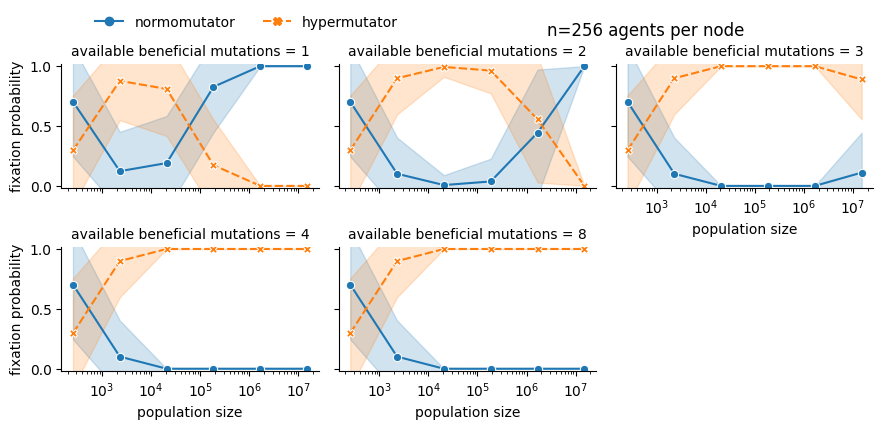

teeplots/cupy-5050-spatial2d-traits/col=available-beneficial-mutations+errorbar=se+hue=genotype+kind=line+style=genotype+viz=relplot+x=population-size+y=fixation-probability+ext=.pdf
teeplots/cupy-5050-spatial2d-traits/col=available-beneficial-mutations+errorbar=se+hue=genotype+kind=line+style=genotype+viz=relplot+x=population-size+y=fixation-probability+ext=.png


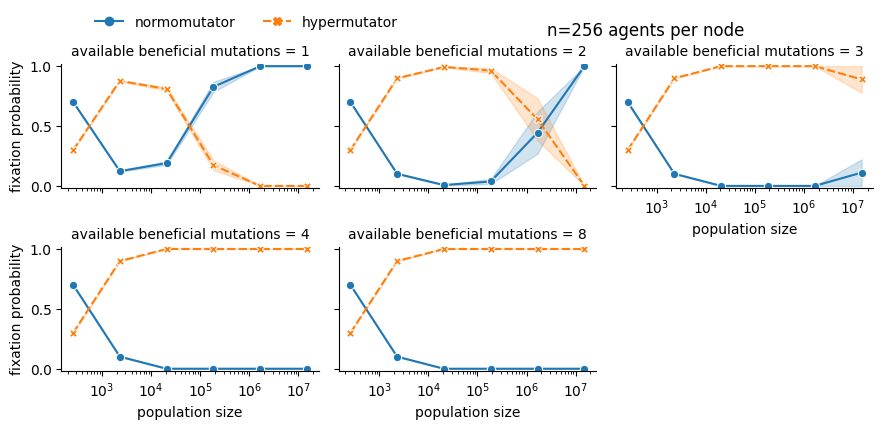

teeplots/cupy-5050-spatial2d-traits/col=available-beneficial-mutations+errorbar=ci+hue=genotype+kind=line+style=genotype+viz=relplot+x=population-size+y=fixation-probability+ext=.pdf
teeplots/cupy-5050-spatial2d-traits/col=available-beneficial-mutations+errorbar=ci+hue=genotype+kind=line+style=genotype+viz=relplot+x=population-size+y=fixation-probability+ext=.png


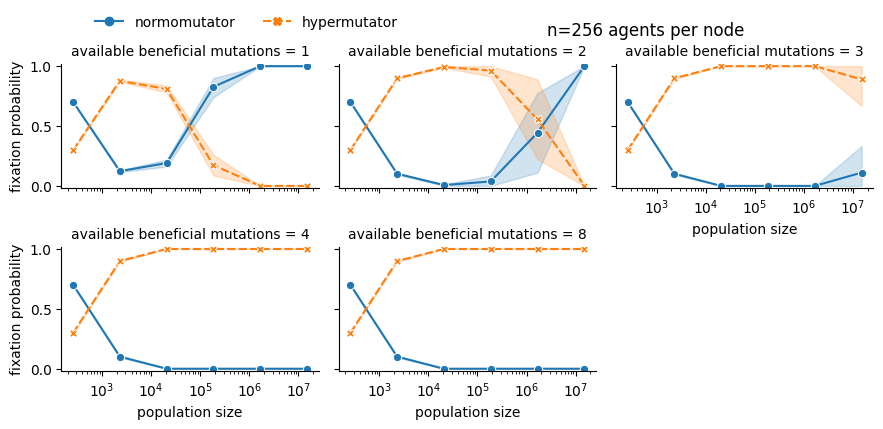

teeplots/cupy-5050-spatial2d-traits/col=available-beneficial-mutations+hue=genotype+kind=line+style=genotype+viz=relplot+x=population-size+y=fixation-probability+ext=.pdf
teeplots/cupy-5050-spatial2d-traits/col=available-beneficial-mutations+hue=genotype+kind=line+style=genotype+viz=relplot+x=population-size+y=fixation-probability+ext=.png


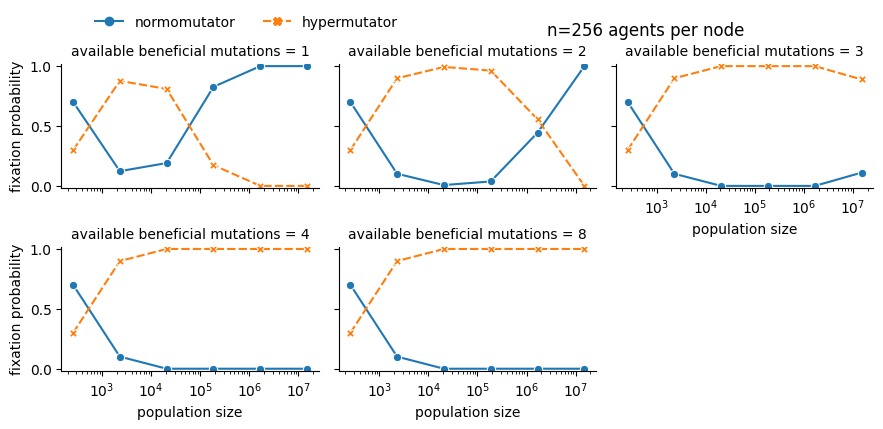

In [8]:
for errorbar in "sd", "se", "ci", None:
    tp.tee(
        sns.relplot,
        data=dfxs,
        x="population size",
        y="fixation probability",
        hue="genotype",
        hue_order=["normomutator", "hypermutator"],
        col="available beneficial mutations",
        style="genotype",
        style_order=["normomutator", "hypermutator"],
        aspect=1.5,
        col_wrap=3,
        errorbar=errorbar,
        height=2,
        kind="line",
        markers=True,
        teeplot_outexclude="post",
        teeplot_subdir=teeplot_subdir,
        teeplot_postprocess=f"""
teed.set(xscale="log", ylim=(-0.02, 1.02))
teed.figure.suptitle("n={apn} agents per node", x=0.63, y=1.02)
teed.set_titles(col_template="{{col_var}} = {{col_name:.0f}}")
sns.move_legend(
    teed,
    "lower center",
    bbox_to_anchor=(0.25, 0.97),
    frameon=False,
    ncol=2,
    title=None,
)
""",
    )


teeplots/cupy-5050-spatial2d-traits/errorbar=sd+hue=available-beneficial-mutations+kind=line+viz=relplot+x=population-size+y=fixation-probability+ext=.pdf
teeplots/cupy-5050-spatial2d-traits/errorbar=sd+hue=available-beneficial-mutations+kind=line+viz=relplot+x=population-size+y=fixation-probability+ext=.png


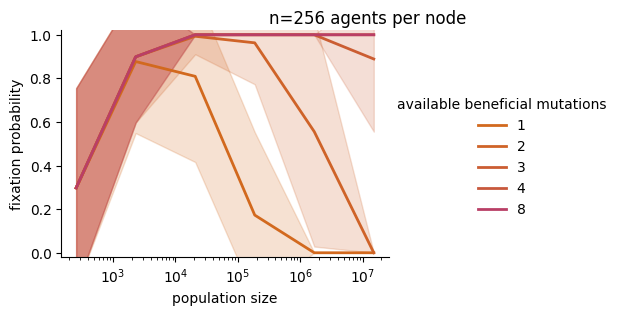

teeplots/cupy-5050-spatial2d-traits/errorbar=se+hue=available-beneficial-mutations+kind=line+viz=relplot+x=population-size+y=fixation-probability+ext=.pdf
teeplots/cupy-5050-spatial2d-traits/errorbar=se+hue=available-beneficial-mutations+kind=line+viz=relplot+x=population-size+y=fixation-probability+ext=.png


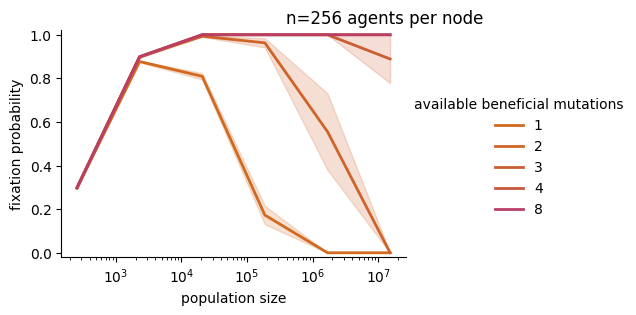

teeplots/cupy-5050-spatial2d-traits/errorbar=ci+hue=available-beneficial-mutations+kind=line+viz=relplot+x=population-size+y=fixation-probability+ext=.pdf
teeplots/cupy-5050-spatial2d-traits/errorbar=ci+hue=available-beneficial-mutations+kind=line+viz=relplot+x=population-size+y=fixation-probability+ext=.png


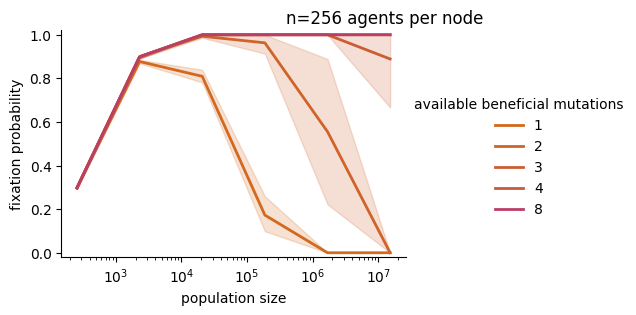

teeplots/cupy-5050-spatial2d-traits/hue=available-beneficial-mutations+kind=line+viz=relplot+x=population-size+y=fixation-probability+ext=.pdf
teeplots/cupy-5050-spatial2d-traits/hue=available-beneficial-mutations+kind=line+viz=relplot+x=population-size+y=fixation-probability+ext=.png


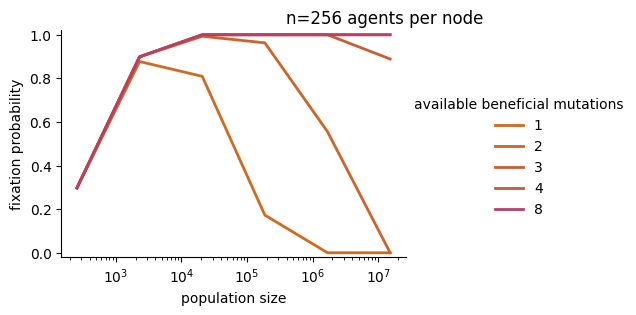

In [9]:
for errorbar in "sd", "se", "ci", None:
    tp.tee(
        sns.relplot,
        data=dfxs[dfxs["genotype"] == "hypermutator"],
        x="population size",
        y="fixation probability",
        hue="available beneficial mutations",
        aspect=1.5,
        height=3,
        kind="line",
        errorbar=errorbar,
        linewidth=2,
        markers=True,
        palette=get_nben_cmap(),
        hue_norm=get_nben_hue_norm(),
        teeplot_outexclude="post",
        teeplot_postprocess=f"""
teed.set(xscale="log", ylim=(-0.02, 1.02))
teed.figure.suptitle("n={apn} agents per node", x=0.63, y=1.02)
teed.set_titles(col_template='{{col_var}} = {{col_name:.0f}}')
""",
        teeplot_subdir=teeplot_subdir,
    )


## Size Fixation Cliffplot


In [10]:
dfxs["available\nbeneficial mutations"] = dfxs[
    "available beneficial mutations"
]


teeplots/cupy-5050-spatial2d-traits/col=population-size+errorbar=ci+hue=genotype+viz=size-fixation-cliffplot+x=fixation-probability+y=available-beneficial-mutations+ext=.pdf
teeplots/cupy-5050-spatial2d-traits/col=population-size+errorbar=ci+hue=genotype+viz=size-fixation-cliffplot+x=fixation-probability+y=available-beneficial-mutations+ext=.png


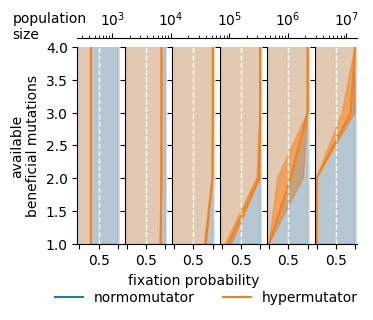

teeplots/cupy-5050-spatial2d-traits/col=population-size+hue=genotype+viz=size-fixation-cliffplot+x=fixation-probability+y=available-beneficial-mutations+ext=.pdf
teeplots/cupy-5050-spatial2d-traits/col=population-size+hue=genotype+viz=size-fixation-cliffplot+x=fixation-probability+y=available-beneficial-mutations+ext=.png


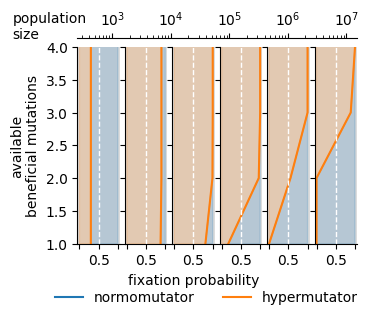

In [11]:
for errorbar in "ci", None:
    tp.tee(
        size_fixation_cliffplot,
        fixprobs_df=dfxs,
        x="fixation probability",
        y="available\nbeneficial mutations",
        col="population size",
        hue="genotype",
        hue_order=["normomutator", "hypermutator"],
        errorbar=errorbar,
        ylim=(1, 4),
        teeplot_subdir=teeplot_subdir,
    )


## Size Fixation Heatmap


teeplots/cupy-5050-spatial2d-traits/genotype=hypermutator+index=available-beneficial-mutations+on=population-size+values=fixation-probability+viz=size-fixation-heatmap+ext=.pdf
teeplots/cupy-5050-spatial2d-traits/genotype=hypermutator+index=available-beneficial-mutations+on=population-size+values=fixation-probability+viz=size-fixation-heatmap+ext=.png


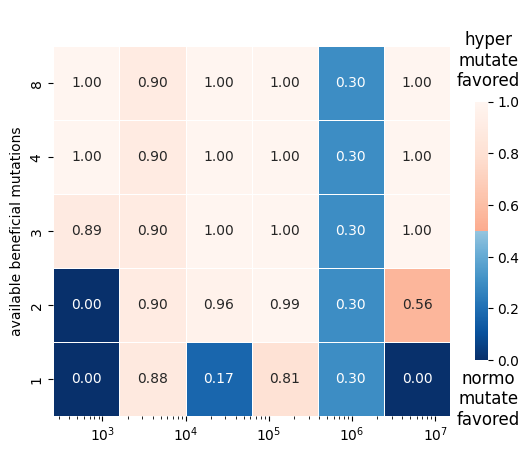

<Axes: ylabel='available beneficial mutations'>

In [12]:
tp.tee(
    size_fixation_heatmap,
    fixprobs_df=dfxs,
    genotype="hypermutator",
    index="available beneficial mutations",
    on="population size",
    values="fixation probability",
    teeplot_subdir=teeplot_subdir,
)


## Quality Check: Number Replicates Available


In [13]:
categories = (
    pl.DataFrame(dfxs)
    .group_by(
        "population size",
    )
    .first()["population size"]
    .sort()
    .cast(pl.String)
    .to_list()
)
categories


['256', '2304', '20736', '186624', '1679616', '15116544']

In [14]:
dfy = pl.DataFrame(dfxs).with_columns(
    pl.col("population size")
    .cast(pl.String)
    .cast(pl.Enum(categories))
    .alias("population size cat"),
)
display(dfy.describe()), display(dfy.head()), display(dfy.tail());


statistic,group,trait value,replicate,population size,available beneficial mutations,fixation probability,genotype,available beneficial mutations,population size cat
str,f64,f64,f64,f64,f64,f64,str,f64,str
"""count""",664380.0,664380.0,664380.0,664380.0,664380.0,664380.0,"""664380""",664380.0,"""664380"""
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,"""0""",0.0,"""0"""
"""mean""",27240.309401,0.5,8.7973e18,3185.400163,3.6,0.5,null,3.6,null
"""std""",17426.555895,0.5,5.9249e18,177129.434115,2.416611,0.5,null,2.416611,null
"""min""",0.0,0.0,5.6291e16,256.0,1.0,0.0,null,1.0,null
"""25%""",11812.0,0.0,4.6339e18,256.0,2.0,0.0,null,2.0,null
"""50%""",25830.0,1.0,5.8283e18,256.0,3.0,1.0,null,3.0,null
"""75%""",42439.0,1.0,1.1601e19,256.0,4.0,1.0,null,4.0,null
"""max""",59048.0,1.0,1.8076e19,1.5116544e7,8.0,1.0,null,8.0,null


group,trait value,replicate,population size,available beneficial mutations,fixation probability,genotype,available beneficial mutations,population size cat
u32,u8,u64,u64,i8,f64,cat,i8,enum
0,0,16718381540940362211,15116544,1,1.0,"""normomutator""",1,"""15116544"""
0,1,16718381540940362211,15116544,1,0.0,"""hypermutator""",1,"""15116544"""
10939,0,4765690112321800547,2304,1,0.0,"""normomutator""",1,"""2304"""
8749,1,4765690112321800547,2304,1,1.0,"""hypermutator""",1,"""2304"""
11921,1,4765690112321800547,2304,1,1.0,"""hypermutator""",1,"""2304"""


group,trait value,replicate,population size,available beneficial mutations,fixation probability,genotype,available beneficial mutations,population size cat
u32,u8,u64,u64,i8,f64,cat,i8,enum
0,1,14681267517012933180,15116544,3,1.0,"""hypermutator""",3,"""15116544"""
0,0,4369920558989525674,15116544,3,0.0,"""normomutator""",3,"""15116544"""
0,1,4369920558989525674,15116544,3,1.0,"""hypermutator""",3,"""15116544"""
0,1,330434490859514516,15116544,3,1.0,"""hypermutator""",3,"""15116544"""
0,0,330434490859514516,15116544,3,0.0,"""normomutator""",3,"""15116544"""


teeplots/cupy-5050-spatial2d-traits/col=available-beneficial-mutations+hue=genotype+kind=hist+multiple=dodge+viz=displot+x=population-size-cat+ext=.pdf
teeplots/cupy-5050-spatial2d-traits/col=available-beneficial-mutations+hue=genotype+kind=hist+multiple=dodge+viz=displot+x=population-size-cat+ext=.png


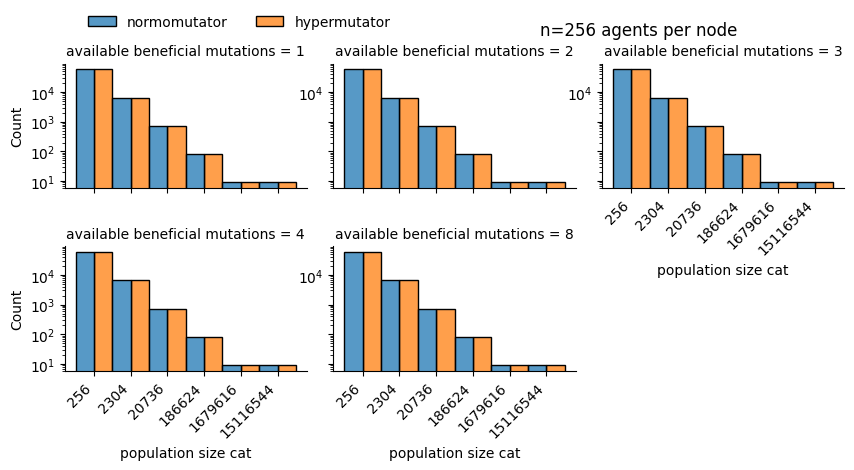

In [15]:
tp.tee(
    sns.displot,
    data=dfy.to_pandas(),
    x="population size cat",
    hue="genotype",
    hue_order=["normomutator", "hypermutator"],
    col="available beneficial mutations",
    aspect=1.5,
    col_wrap=3,
    height=2,
    kind="hist",
    multiple="dodge",
    teeplot_outexclude="post",
    teeplot_postprocess=f"""
teed.set(yscale='log')
teed.figure.suptitle("n={apn} agents per node", x=0.63, y=1.02)
teed.set_titles(col_template='{{col_var}} = {{col_name:.0f}}')
for ax in teed.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha("right")
sns.move_legend(
    teed, "lower center",
    bbox_to_anchor=(0.25, 0.97),
    frameon=False,
    ncol=2,
    title=None,
)
""",
    teeplot_subdir=teeplot_subdir,
)


## Quality Check: Has Reached Fixation?


In [16]:
dfxs_ = dfxs[dfxs["genotype"] == "hypermutator"].copy().reset_index(drop=True)


In [17]:
dfxs_["unfixed"] = (dfxs_["fixation probability"] != 1.0) & (
    dfxs_["fixation probability"] > 0.001
)
any_unfixed = dfxs_["unfixed"].any()
any_unfixed


np.False_

teeplots/cupy-5050-spatial2d-traits/hue=genotype+kind=scatter+style=genotype+viz=relplot+x=population-size+y=fixation-probability+ext=.pdf
teeplots/cupy-5050-spatial2d-traits/hue=genotype+kind=scatter+style=genotype+viz=relplot+x=population-size+y=fixation-probability+ext=.png


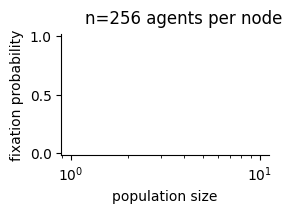

In [18]:
tp.tee(
    sns.relplot,
    data=dfxs_[dfxs_["unfixed"]],
    x="population size",
    y="fixation probability",
    hue="genotype",
    hue_order=["normomutator", "hypermutator"],
    col=[None, "available beneficial mutations"][int(any_unfixed)],
    style="genotype",
    style_order=["normomutator", "hypermutator"],
    aspect=1.5,
    col_wrap=[None, 3][int(any_unfixed)],
    height=2,
    kind="scatter",
    markers=bool(any_unfixed),
    teeplot_outexclude="post",
    teeplot_postprocess=f"""
teed.set(xscale='log', ylim=(-0.02, 1.02))
teed.figure.suptitle("n={apn} agents per node", x=0.63, y=1.02)
teed.set_titles(col_template='{{col_var}} = {{col_name:.0f}}')
try:
    sns.move_legend(
        teed,
        "lower center",
        bbox_to_anchor=(0.25, 0.97),
        frameon=False,
        ncol=2,
        title=None,
    )
except ValueError:
    pass
""",
    teeplot_subdir=teeplot_subdir,
)


teeplots/cupy-5050-spatial2d-traits/col=available-beneficial-mutations+hue=unfixed+multiple=fill+viz=displot+x=population-size+ext=.pdf
teeplots/cupy-5050-spatial2d-traits/col=available-beneficial-mutations+hue=unfixed+multiple=fill+viz=displot+x=population-size+ext=.png


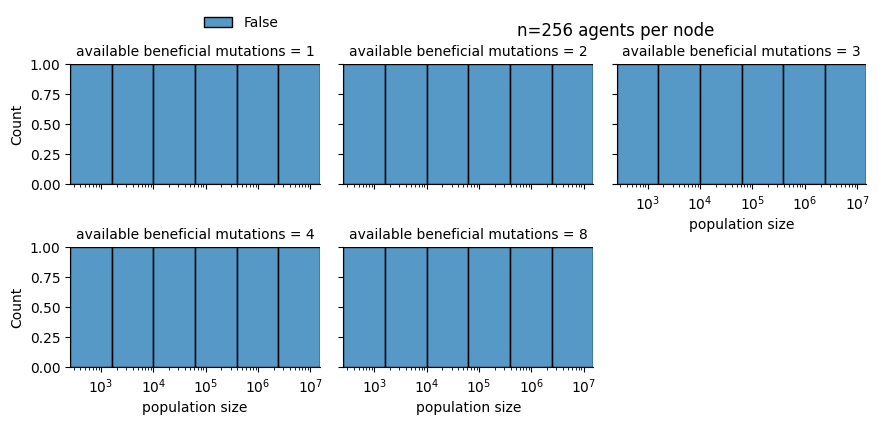

In [19]:
tp.tee(
    sns.displot,
    data=dfxs_.reset_index(drop=True),
    x="population size",
    hue="unfixed",
    col="available beneficial mutations",
    col_wrap=3,
    aspect=1.5,
    height=2,
    multiple="fill",
    bins=dfxs_["population size"].nunique(),
    log_scale=(True, False),
    teeplot_outexclude="post",
    teeplot_postprocess=f"""
teed.figure.suptitle("n={apn} agents per node", x=0.63, y=1.02)
teed.set_titles(col_template='{{col_var}} = {{col_name:.0f}}')
sns.move_legend(
    teed,
    "lower center",
    bbox_to_anchor=(0.25, 0.97),
    frameon=False,
    ncol=2,
    title=None,
)
""",
    teeplot_subdir=teeplot_subdir,
)
